# Using pycalphad

## TMS 2018 Workshop, March 11, 2018
### A Tutorial by Matthew Feurer, Brandon Bocklund and Richard Otis



# Installation

Due to limited time we will be using a cloud-based installation of pycalphad. (Instructions are provided separately for accessing this.) For long-term usage we recommend installing on your local machine and/or HPC cluster environment. Details can be found here: https://pycalphad.org/docs/latest/INSTALLING.html

# Introduction to pycalphad
## Opening a Database
Any calculation in pycalphad requires you to define:
* A Database object
* The components to consider (including 'VA' for vacancies)
* The phases to consider
* The conditions of the calculation

In Python, you need to `import` the tools to perform the calculation. They act as additions to the basic Python language. In general you can copy them as you see here without any modification. At the begining of any new session you must run these import statements to get all the tools we need.

In [1]:
from pycalphad import Database

When using the `Database()` command you can load a database. You can use a filename or paste the entire TDB as a multi-line string.

**NOTE**: The code below works only if your .TDB file is in the same file location as your Jupyter notebook (current working directory). You can also specify a full file path (e.g., `E:/Literature/literature/Al-Co-Cr-Ni/mydb.TDB`).

In [2]:
db = Database('Cr-Fe-Ni.tdb')

## Looking at the Contents of Databases
Databases contain lots of information, much of which will help us set up calculations. Some useful things to look at are:
- the elements
- the phases
- the consituents of a particular phase

We can see all of these using the following commands:

In [3]:
# the print() command will output anything that is specified, it can be used with variables and text  
print("The elements contained in this database are:")
print(db.elements)                      #this prints the elements defined in the loaded database

print("The phases contained in this database are:")
print(list(db.phases.keys()))           #this prints the phases

print("The constituents of the SIGMA phase are:")
print(db.phases['SIGMA'].constituents)  #this prints the constituents of a specified phase


The elements contained in this database are:
{'/-', 'VA', 'FE', 'CR', 'NI'}
The phases contained in this database are:
['BCC_A2', 'HCP_A3', 'FCC_A1', 'SIGMA', 'LIQUID']
The constituents of the SIGMA phase are:
(frozenset({Species('FE', 'FE1'), Species('NI', 'NI1')}), frozenset({Species('CR', 'CR1')}), frozenset({Species('FE', 'FE1'), Species('CR', 'CR1'), Species('NI', 'NI1')}))


## Setting Conditions & Running Equilibrium Calculations
In any thermodynamic calculation, $c+2$ conditions must be defined for $c$ components. In pycalphad, we calculate with the implicit condition that $N=1$, so all calculations must have $c+1$ conditions specified.

Each condition, pressure, temperature and composition are accessed via by prepending the type with a "v.":

- **Pressure:** v.P in Pascals. Standard pressure is 101325Pa by convention.
- **Temperature:** v.T in Kelvin. Most databases are only defined between 298.15 K and 6000 K.
- **Composition:** v.X('NI') as a mole fraction (for Ni).

## The equilibrium() & calculate() Functions
In the following code and the following example we will be using the equilibrium() and calculate() tools. These functions require you to specify  a database, components, phases and conditions. You can also specify an output using keywords from the following list:

- Molar Enthalpy($H_M$) ------- 'HM'
- Molar Gibbs($G_M$) ----------- 'GM'
- Molar Entropy($S_M$) --------- 'SM'
- Heat Capacity($C_p$) --------- 'heat_capacity'
- Degree of Ordering -------- 'degree_of_ordering' or 'DOO'
- Molar Heat capacity-------- 'CPM'

In [4]:
from pycalphad import equilibrium
from pycalphad import variables as v

# Define components:
# Note: must have the correct capitialization.
# CALPHAD modelers usually use all-caps by convention.
# Also note that we include VA. Always do this.
components = ['CR', 'VA'] 

# Define the phases:
phases = ['LIQUID', 'BCC_A2', 'FCC_A1']

# And the conditions:
# This is a map of the variable to its value
conditions = {v.P: 101325, v.T: 500}

# do the equlibrium calculation and store the result in the `eq` variable
eq = equilibrium(db, components, phases, conditions)
print(eq)

<xarray.Dataset>
Dimensions:    (P: 1, T: 1, component: 1, internal_dof: 2, vertex: 1)
Coordinates:
  * T          (T) float64 500.0
  * component  (component) <U2 'CR'
  * vertex     (vertex) int64 0
  * P          (P) float64 1.013e+05
Dimensions without coordinates: internal_dof
Data variables:
    Y          (P, T, vertex, internal_dof) float64 1.0 1.0
    Phase      (P, T, vertex) <U6 'BCC_A2'
    NP         (P, T, vertex) float64 1.0
    X          (P, T, vertex, component) float64 1.0
    MU         (P, T, component) float64 -1.316e+04
    GM         (P, T) float64 -1.316e+04
Attributes:
    engine:   pycalphad 0.6.1+69.g7562a867
    created:  2018-03-10T21:03:37.407462


## Plotting: $C_p$ vs T
plotting is an important part of looking at data. graphing data in pycalphad is made easy with matplotlib. Here we will run through the steps above more quickly to calculate $C_p$ and plot the results. 
### Importing Libraries
Now that we know how to define variables lets try to calculate the heat capacity for cementite. first lets start by importing the libraries(tools) that we will need to do this calculation. Matplotlib will enable us to view our data in plots. It comes with a variety of tools for ploting and displaying data. Numpy adds math tools used in our calculations. By convention it is a good idea to put import statements at the top of your code.

In [5]:
# Only needed in a Jupyter Notebook
%matplotlib inline
import matplotlib
# Optional plot styling
matplotlib.style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
from pycalphad import Database, calculate

### Defining our TDB
In this example we will be defining the database by writing it directly into our code. This is also a good opportunity to look at the structure of databases.

In [6]:
# Reference: Bengt Hallstedt et al, "Thermodynamic properties of cementite," Calphad, Volume 34, Issue 1, March 2010, Pages 129-133
# http://dx.doi.org/10.1016/j.calphad.2010.01.004
TDB = """
 ELEMENT C    GRAPHITE                   12.011     1054.0      5.7423 !
 ELEMENT FE   BCC_A2                     55.847     4489.0     27.2797 !
 TYPE_DEFINITION % SEQ * !
 TYPE_DEFINITION A GES AMEND_PHASE_DESCRIPTION @ MAGNETIC -3 0.28 !
 PHASE CEMENTITE_D011 %A 2 3 1 !
 CONSTITUENT CEMENTITE_D011 : FE : C : !
 PARAMETER  G(CEMENTITE_D011,FE:C;0) 0.01 +GFECEM; 6000 N !
 PARAMETER  TC(CEMENTITE_D011,FE:C;0) 0.01 485.00; 6000 N !
 PARAMETER  BMAGN(CEMENTITE_D011,FE:C;0) 0.01 1.008; 6000 N !
 FUNCTION GFECEM      0.01  +11369.937746-5.641259263*T-8.333E-6*T**4;
        43.00  Y  +11622.647246-59.537709263*T+15.74232*T*LN(T)
       -0.27565*T**2;
       163.00  Y  -10195.860754+690.949887637*T-118.47637*T*LN(T)
                  -0.0007*T**2+590527*T**(-1);
      6000.00  N !
"""
your_database = Database(TDB)

### Calculating
Now that we have loaded our database we can run calculations.

For this we use the `calculate()` command. Using a database, in this case `your_database`, we will be calculating heat_capacity in the Fe-C system for the Cementite phase (CEMENTITE_D011) between 1K-2000K with a step size of 0.5K.

In [7]:
result = calculate(your_database, ['FE', 'C'], 'CEMENTITE_D011', T=(1, 2000, 0.5), output='heat_capacity')

### Plotting
Below is just a small sample of the commands that can be used to plot using matplotlib. There are many other tools that change the appearance of the figures it generates, as well as commands that can save figures as images in various file formats. See the matplotlib website for details: https://matplotlib.org/index.html

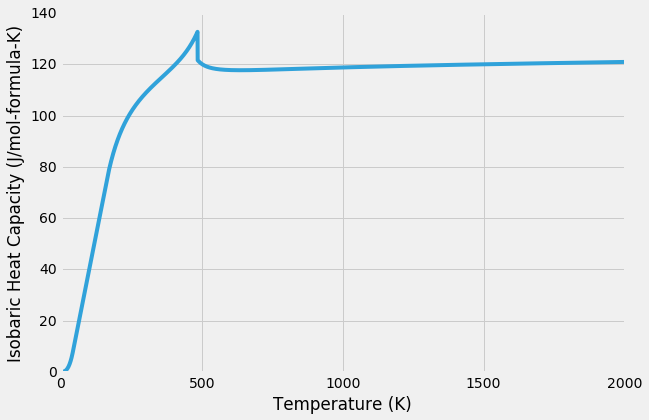

In [8]:
# Note: 4 moles of atoms per formula unit (Fe3C1). That's why we multiply times 4
fig = plt.figure(figsize=(9,6)) # plt is the alias we set for matplotlib 
fig.gca().set_xlabel('Temperature (K)')
fig.gca().set_ylabel('Isobaric Heat Capacity (J/mol-formula-K)')
fig.gca().plot(result['T'], np.squeeze(4.0 * result['heat_capacity']))
plt.show()

## Calculating Energy Surfaces
It is very common in CALPHAD modeling to directly examine the Gibbs energy surface of all the constituent phases in a system.

Below we show how the Gibbs energy of all phases may be calculated as a function of composition at a given temperature (2800 K).

Note that the chi phase has additional, internal degrees of freedom which allow it to take on multiple states for a given overall composition. Only the low-energy states are relevant to calculating the equilibrium phase diagram.

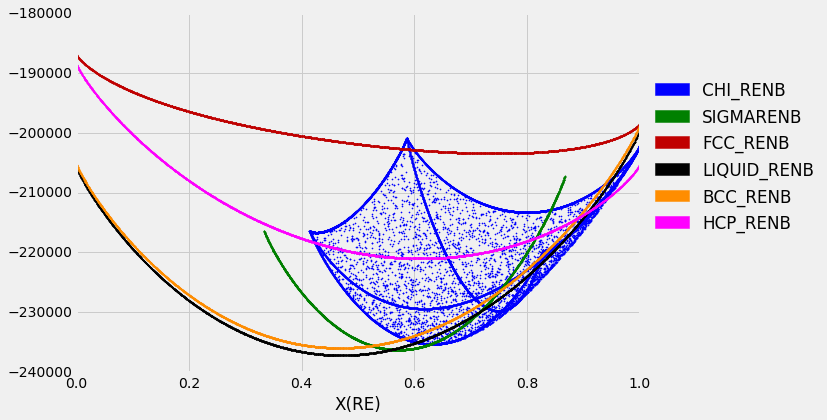

In [9]:
from pycalphad import calculate
from pycalphad.plot.utils import phase_legend
import numpy as np

db_nbre = Database('nbre_liu.tdb')
my_phases_nbre = ['CHI_RENB', 'SIGMARENB', 'FCC_RENB', 'LIQUID_RENB', 'BCC_RENB', 'HCP_RENB']

legend_handles, colorlist = phase_legend(my_phases_nbre)

fig = plt.figure(figsize=(9,6))
ax = fig.gca()
for name in my_phases_nbre:
    result = calculate(db_nbre, ['NB', 'RE'], name, P=101325, T=2800, output='GM')
    ax.scatter(result.X.sel(component='RE'), result.GM,
               marker='.', s=5, color=colorlist[name.upper()])
ax.set_xlim((0, 1))
ax.set_xlabel('X(RE)')
ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.6))
plt.show()



# Calculating phase fractions versus temperature

Computing the equilibrium phase fractions versus temperature is a useful and easy first step in trying to understand solidification behavior of an alloy.

In [15]:
dbf = Database('Cr-Fe-Ni.tdb')
phases = sorted(dbf.phases.keys())
eq = equilibrium(dbf, ['CR', 'FE', 'NI', 'VA'], phases, {v.T: (500, 900, 10), v.P: 101325, v.X('CR'): 0.1, v.X('NI'): 0.2})

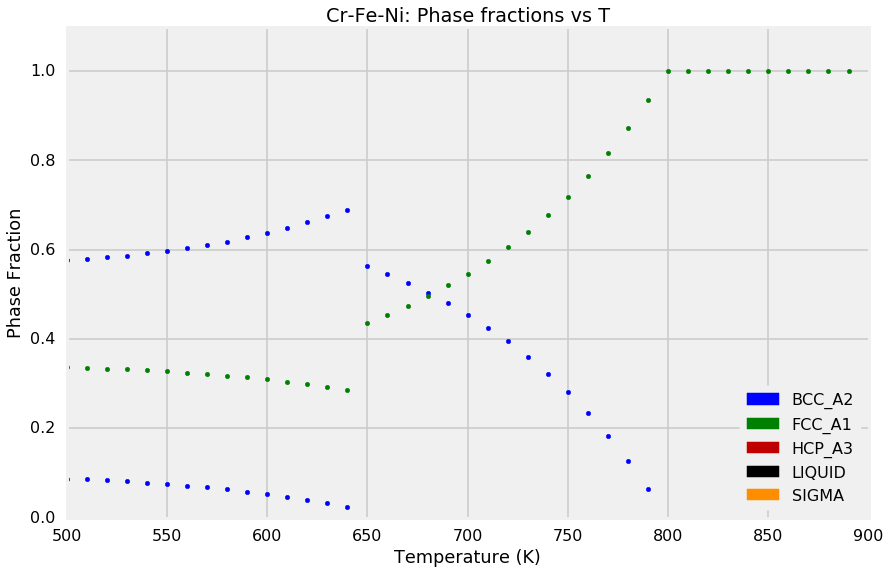

In [16]:
from pycalphad.plot.utils import phase_legend
phase_handles, phasemap = phase_legend(phases)

plt.gca().set_title('Cr-Fe-Ni: Phase fractions vs T')
plt.gca().set_xlabel('Temperature (K)')
plt.gca().set_ylabel('Phase Fraction')
plt.gca().set_ylim((0,1.1))
plt.gca().set_xlim((500, 900))

for name in phases:
    phase_indices = np.nonzero(eq.Phase.values == name)
    plt.scatter(np.take(eq['T'].values, phase_indices[1]), eq.NP.values[phase_indices], color=phasemap[name])
plt.gca().legend(phase_handles, phases, loc='lower right')


# Custom Phase Model Properties
A powerful feature of pycalphad is the ability to define custom properties of phases, which can then be computed the same as built-in properties like enthalpy.

(It is even possible to modify how the Gibbs energy itself is calculated. An example is shown here: https://github.com/richardotis/2017workshop/blob/master/FeMn-CustomModel.ipynb )

For this case, we want to plot the different contributions to the heat capacity.
First, we define a custom model with all the custom properties.

In [12]:
from pycalphad import Model
class CustomModel(Model):
    magnetic_cpm = property(lambda self: -v.T*self.models['mag'].diff(v.T, v.T))
    einstein_cpm = property(lambda self: -v.T*self.models['ein'].diff(v.T, v.T))
    excess_cpm = property(lambda self: -v.T*self.models['xsmix'].diff(v.T, v.T))
    ideal_cpm = property(lambda self: -v.T*self.models['idmix'].diff(v.T, v.T))
    ref_cpm = property(lambda self: -v.T*self.models['ref'].diff(v.T, v.T))

In [13]:
import numpy as np
from pycalphad import Database, equilibrium, variables as v
dbf = Database('FeMn.tdb')
eq = equilibrium(dbf, ['FE', 'MN', 'VA'], 'FCC_A1', {v.T: (300, 2000, 10), v.P: 101325, v.X('MN'): 0.3}, 
               output=['magnetic_cpm', 'excess_cpm', 'ideal_cpm', 'ref_cpm', 'einstein_cpm', 'CPM'],
                 model=CustomModel)

cpm_stack = np.cumsum([eq['ref_cpm'].values.flatten(),
                       eq['ideal_cpm'].values.flatten(),
                       eq['excess_cpm'].values.flatten(),
                       eq['einstein_cpm'].values.flatten(),
                       eq['magnetic_cpm'].values.flatten()
                      ], axis=0)

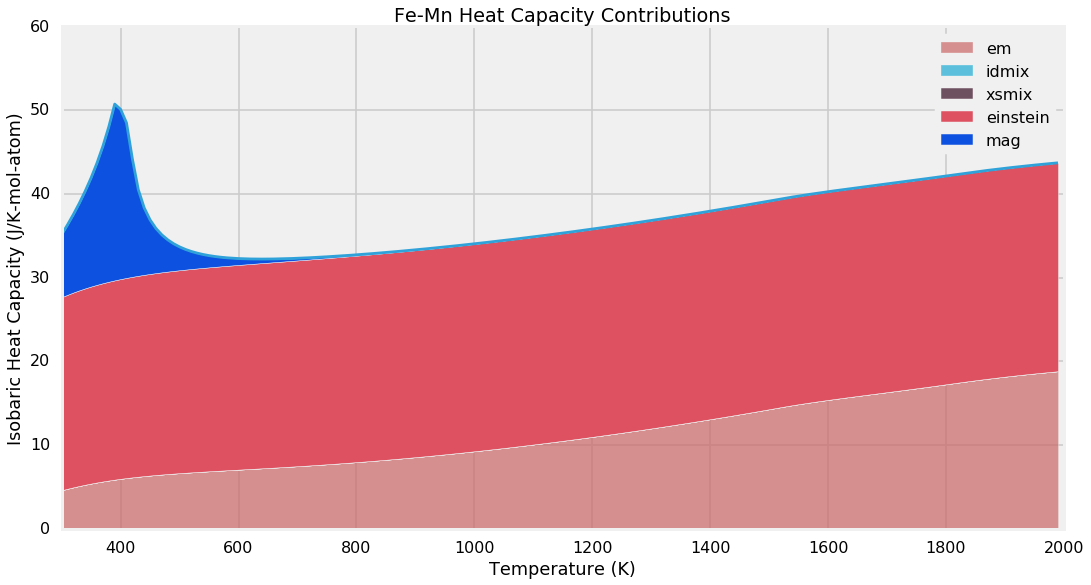

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
matplotlib.style.use('seaborn-poster')

fig = plt.figure(figsize=(16,9))
ax = fig.gca()
temps = eq['T'].values.flatten()
ax.plot(temps, eq['CPM'].values.flatten())
ax.fill_between(temps, 0, cpm_stack[0,:], facecolor="#CC6666", alpha=.7, label='em')
ax.fill_between(temps, cpm_stack[0,:], cpm_stack[1,:], facecolor="#1DACD6", alpha=.7, label='idmix')
ax.fill_between(temps, cpm_stack[1,:], cpm_stack[2,:], facecolor="#6E5160", label='xsmix')
ax.fill_between(temps, cpm_stack[2,:], cpm_stack[3,:], facecolor="#DD5160", label='einstein')
ax.fill_between(temps, cpm_stack[3,:], cpm_stack[4,:], facecolor="#0D51E0", label='mag')
ax.set_xlabel('Temperature (K)')
ax.set_xlim((300,None))
ax.set_ylabel('Isobaric Heat Capacity (J/K-mol-atom)')
ax.legend()
plt.title('Fe-Mn Heat Capacity Contributions')
plt.show()

# More Information
For technical support, contact Richard Otis: richard.otis@outlook.com

The pycalphad community also has a chat channel on Gitter: https://gitter.im/pycalphad/pycalphad

https://pycalphad.org